calculamos los distintos features:

In [60]:
import numpy as np
import seaborn as sns
import scipy.io as sio
import pandas as pd

from math import ceil, log, log10
from random import randint
from scipy import interp
from scipy.stats import ranksums, bartlett, describe
from scipy.signal import welch
from scipy.fftpack import rfft
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV
from sklearn.svm import SVC

plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
#### CARGAR TODOS LOS DF ####
bandas_no_normalizadas = pd.read_pickle("poder_espectral_no_norm.df")
bandas_normalizadas = pd.read_pickle("poder_espectral_norm.df")
tablaCantBines = pd.read_pickle('bins_con_entropia.df')
interelectrodo = pd.read_pickle('../tp2/interelectrodo.df')[['mean_mutual_81_167', 'std_mutual81_167','Tipo']]

In [2]:
filenamesP = ['../tp2/dataset/P0'+str(i)+'.mat' for i in range(1,10)]+['../tp2/dataset/P10.mat']
filenamesS = ['../tp2/dataset/S0'+str(i)+'.mat' for i in range(1,10)]+['../tp2/dataset/S10.mat']
bandas = ['delta_mean', 'epsilon_mean', 'alfa_mean', 'beta_mean', 'gamma_mean',
          'delta_std',  'epsilon_std',  'alfa_std',  'beta_std',  'gamma_std']

In [3]:
def FrecuenciasPorTipo(archivos, grupo):
    freqPotXPersona = []
    for filename in archivos:
        array = sio.loadmat(filename)['data']
        ffs = []
        for i in range(256):
            muestras= array[:,i][0]
            ff= welch(muestras, fs=250, nperseg=201)
            ffs.append(ff[1])
        frecuencia = ff[0]
        arrayffs = np.array(ffs)
        freqPotXPersona.append((frecuencia,arrayffs.mean(axis=0)))
#     for index, freqPot in enumerate(freqPotXPersona):
#         plt.plot(freqPot[0],freqPot[1], label=grupo+str(index+1))
#     plt.legend(loc='best')
#     plt.xlim(0,50)
#     plt.show()
    
    return freqPotXPersona

def PromedioBandas(freqPotXPersona):
    proms = []
    stds = []
    for j in range(len(freqPotXPersona)):
        proms.append([])
        stds.append([])
        freqPot = freqPotXPersona[j]
        buckets = [[],[],[],[],[]]
        for i in range(len(freqPot[1])):
            if freqPot[0][i] < 4:
                buckets[0].append(freqPot[1][i])
            elif freqPot[0][i] < 8:
                buckets[1].append(freqPot[1][i])
            elif freqPot[0][i] < 13:
                buckets[2].append(freqPot[1][i])
            elif freqPot[0][i] < 30:
                buckets[3].append(freqPot[1][i])
            else:
                buckets[4].append(freqPot[1][i])
        
        for i in range(len(buckets)):
            buckets[i] = np.array(buckets[i])
            proms[j].append(buckets[i].mean())
            stds[j].append(buckets[i].std())

    return proms, stds
    

In [4]:
frecuenciasP = FrecuenciasPorTipo(filenamesP,'P') #FrecuenciasPorTipo plotea
frecuenciasS = FrecuenciasPorTipo(filenamesS, 'S')

bandasP_mean, bandasP_std = PromedioBandas(frecuenciasP)
bandasS_mean, bandasS_std= PromedioBandas(frecuenciasS)

for i in range(len(bandasP_mean)):
    bandasP_mean[i] += bandasP_std[i]
    bandasS_mean[i] += bandasS_std[i]

In [2]:
# tablaP = pd.DataFrame(bandasP_mean, columns=bandas, index=['P'+str(i) for i in range(1,11)])
# tablaS = pd.DataFrame(bandasS_mean, columns=bandas, index=['S'+str(i) for i in range(1,11)])
# tablaP['Tipo'] = 'P'
# tablaS['Tipo'] = 'S'

# bandas_no_normalizadas = pd.concat([tablaP, tablaS])
# bandas_no_normalizadas.to_pickle("poder_espectral_no_norm.df")
bandas_no_normalizadas = pd.read_pickle("poder_espectral_no_norm.df")
bandas_no_normalizadas

,delta_mean,epsilon_mean,alfa_mean,beta_mean,gamma_mean,delta_std,epsilon_std,alfa_std,beta_std,gamma_std,Tipo
P1,1.013976e-11,2.114767e-12,8.597311e-13,1.357580e-12,2.591455e-13,6.045476e-12,7.788568e-13,1.333585e-13,6.366335e-13,6.654151e-13,P
P2,2.776192e-11,2.215931e-12,9.486518e-13,1.045988e-12,6.248615e-14,1.511155e-11,1.298956e-12,4.012490e-13,7.667534e-13,1.537834e-13,P
P3,4.401700e-11,3.088734e-12,4.638416e-13,1.285836e-13,9.613761e-15,3.942157e-11,1.782672e-12,2.064160e-13,7.283282e-14,2.408212e-14,P
P4,1.271719e-11,2.069442e-12,6.338850e-13,1.795954e-13,2.505703e-14,9.639446e-12,5.061183e-13,3.236940e-13,8.102794e-14,5.977254e-14,P
P5,1.064783e-11,1.700377e-12,9.192861e-13,9.914341e-13,1.323664e-13,7.996042e-12,4.632076e-13,2.727212e-13,2.757409e-13,3.181502e-13,P
P6,2.963112e-11,3.205336e-12,9.813531e-13,1.040890e-13,4.314605e-15,2.381545e-11,1.785273e-12,4.745956e-13,6.902684e-14,1.041625e-14,P
P7,3.774570e-11,3.035294e-12,8.245702e-13,3.797379e-13,1.783728e-14,3.252223e-11,1.687106e-12,1.848769e-13,1.867929e-13,3.952592e-14,P
P8,5.007863e-12,6.279532e-13,1.586481e-13,6.357998e-14,3.537354e-15,4.582997e-12,1.221504e-13,6.790768e-14,2.677355e-14,8.280548e-15,P
P9,2.225498e-11,4.619804e-12,1.409964e-12,9.723751e-13,8.611592e-14,1.286787e-11,1.077725e-12,2.246167e-13,2.590636e-13,2.191839e-13,P
P10,7.377688e-12,3.839709e-12,7.654888e-13,8.862251e-13,1.088521e-13,3.596349e-12,2.016596e-12,1.074745e-13,3.341737e-13,2.520218e-13,P


#### Bandas normalizadas

In [3]:
# bandas_normalizadas = bandas_no_normalizadas.copy(deep=True)

# for fila in bandas_normalizadas.index:
#     suma_mean = bandas_normalizadas.loc[fila][:5].sum()
#     suma_std =  bandas_normalizadas.loc[fila][5:-1].sum()
#     for col in bandas_normalizadas.columns:
#         if "mean" in col:
#             bandas_normalizadas.loc[fila,col] /= suma_mean
#         elif "std" in col:
#             bandas_normalizadas.loc[fila,col] /= suma_std

# bandas_normalizadas.to_pickle("poder_espectral_norm.df")
bandas_normalizadas = pd.read_pickle("poder_espectral_norm.df")
bandas_normalizadas

,delta_mean,epsilon_mean,alfa_mean,beta_mean,gamma_mean,delta_std,epsilon_std,alfa_std,beta_std,gamma_std,Tipo
P1,0.688329,0.143559,0.058362,0.092158,0.017592,0.731921,0.094296,0.016146,0.077077,0.080561,P
P2,0.866613,0.069172,0.029613,0.032651,0.001951,0.852205,0.073254,0.022628,0.043241,0.008673,P
P3,0.922638,0.064743,0.009723,0.002695,0.000202,0.949744,0.042948,0.004973,0.001755,0.000580,P
P4,0.813891,0.132443,0.040568,0.011494,0.001604,0.908520,0.047702,0.030508,0.007637,0.005634,P
P5,0.739880,0.118153,0.063878,0.068891,0.009198,0.857405,0.049669,0.029244,0.029567,0.034115,P
P6,0.873399,0.094480,0.028926,0.003068,0.000127,0.910559,0.068258,0.018146,0.002639,0.000398,P
P7,0.898640,0.072264,0.019631,0.009041,0.000425,0.939391,0.048731,0.005340,0.005395,0.001142,P
P8,0.854354,0.107130,0.027066,0.010847,0.000603,0.953181,0.025405,0.014124,0.005568,0.001722,P
P9,0.758436,0.157440,0.048051,0.033138,0.002935,0.878445,0.073573,0.015334,0.017685,0.014963,P
P10,0.568478,0.295864,0.058984,0.068287,0.008387,0.570250,0.319759,0.017042,0.052988,0.039961,P


####  Medida de la informacion intra-electrodo (entropia media)

In [4]:
tablaCantBines = pd.read_pickle('../tp2/bins.df')
tablaCantBines

,cant_bins,max,min
dataset/P01.mat,442.0,0.000020,-0.000020
dataset/P02.mat,398.0,0.000025,-0.000025
dataset/P03.mat,433.0,0.000028,-0.000029
dataset/P04.mat,418.0,0.000020,-0.000020
dataset/P05.mat,397.0,0.000027,-0.000027
dataset/P06.mat,449.0,0.000024,-0.000023
dataset/P07.mat,395.0,0.000023,-0.000024
dataset/P08.mat,472.0,0.000015,-0.000015
dataset/P09.mat,398.0,0.000026,-0.000026
dataset/P10.mat,421.0,0.000020,-0.000020


In [7]:
def discretizar(muestras, paciente_filename):
    N = tablaCantBines.at[paciente_filename,'cant_bins']
    maximo = tablaCantBines.at[paciente_filename,'max']
    minimo = tablaCantBines.at[paciente_filename,'min']
    bin_size = (maximo-minimo)/N
    discretizacion = np.array([0] * len(muestras))
    for i in range(len(muestras)):
        if muestras[i] < minimo:
            discretizacion[i] = 0
        elif muestras[i] > maximo:
            discretizacion[i] = N
        else:
            discretizacion[i] = int((muestras[i] - minimo) / bin_size)
    return discretizacion
def divideN(elem):
    return np.float32(elem)/201


def get_entropia(muestras, N):
    buckets =np.histogram(muestras, bins=int(N), range=(0.0, N))[0]
    assert np.sum(buckets) == 201
    buckets = np.apply_along_axis(func1d=divideN, axis=0, arr=buckets)
    # con eso nos quedan las frecuencias
    h = 0
    for value in buckets:
        if value > 0:
            h += value * log(value)
    return -h

In [8]:
def obtener_entropia_media(paciente_filename):
    paciente  = sio.loadmat('../tp2/' + paciente_filename)['data']
    cant_epochs = paciente.shape[0]
    cant_electrodos = paciente.shape[1]

    cantidad_mediciones = 10000
    entropia = []

    for a in range(cantidad_mediciones):
        epoch = randint(0,cant_epochs-1)
        electrodo = randint(0,cant_electrodos-1)
        disc = discretizar(paciente[epoch][electrodo], paciente_filename)
        entropia.append(get_entropia(disc, tablaCantBines.at[paciente_filename,'cant_bins']))
    
    entropia = np.array(entropia)
    return (entropia.mean(), entropia.std())

In [5]:
# for paciente_filename in tablaCantBines.index:
#     print paciente_filename
#     tablaCantBines.at[paciente_filename,"mean_entropy"], tablaCantBines.at[paciente_filename,"std_entropy"] = \
#     obtener_entropia_media(paciente_filename)
# tablaCantBines.to_pickle('bins_con_entropia.df')
tablaCantBines = pd.read_pickle('bins_con_entropia.df')
tablaCantBines

,cant_bins,max,min,mean_entropy,std_entropy
dataset/P01.mat,442.0,0.000020,-0.000020,4.559381,0.438055
dataset/P02.mat,398.0,0.000025,-0.000025,4.568171,0.363216
dataset/P03.mat,433.0,0.000028,-0.000029,4.513985,0.410765
dataset/P04.mat,418.0,0.000020,-0.000020,4.563222,0.418210
dataset/P05.mat,397.0,0.000027,-0.000027,4.589381,0.393151
dataset/P06.mat,449.0,0.000024,-0.000023,4.528059,0.456498
dataset/P07.mat,395.0,0.000023,-0.000024,4.588264,0.372754
dataset/P08.mat,472.0,0.000015,-0.000015,4.566092,0.422429
dataset/P09.mat,398.0,0.000026,-0.000026,4.597163,0.430269
dataset/P10.mat,421.0,0.000020,-0.000020,4.534647,0.409715


#### Medida de la informacion inter-electrodo

In [6]:
interelectrodo = pd.read_pickle('../tp2/interelectrodo.df')[['mean_mutual_81_167', 'std_mutual81_167','Tipo']]
# interelectrodo['Tipo'] = interelectrodo['Tipo'] == 'S'
interelectrodo


,mean_mutual_81_167,std_mutual81_167,Tipo
dataset/P01.mat,1.561002,0.286349,P
dataset/P02.mat,1.401908,0.275429,P
dataset/P03.mat,1.372638,0.270736,P
dataset/P04.mat,1.303941,0.265594,P
dataset/P05.mat,1.501296,0.196882,P
dataset/P06.mat,1.279751,0.295940,P
dataset/P07.mat,1.513530,0.258878,P
dataset/P08.mat,1.493793,0.264465,P
dataset/P09.mat,1.486228,0.299368,P
dataset/P10.mat,1.308798,0.281550,P


## Ejericio 2.1.a: Para cada feature, computar la curva ROC y graficarla

Interelectrodo e intraelectrodo


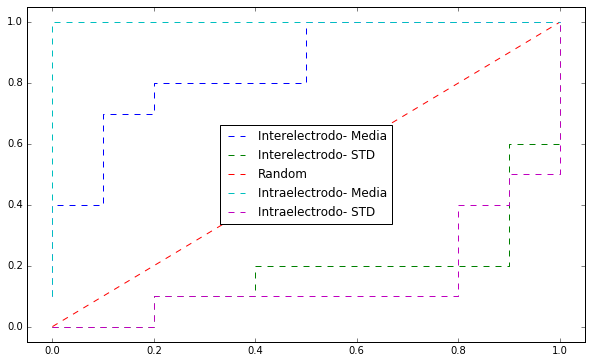

In [15]:
def Max_AUC(labels, scores):
    auc1 = roc_auc_score([t == 'S' for t in labels], scores)
    auc2 = roc_auc_score([t == 'P' for t in labels], scores)
    return max(auc1, auc2)

#Inter y intraelectrodo
print "Interelectrodo e intraelectrodo"
roc_curva = roc_curve(interelectrodo['Tipo'], interelectrodo['mean_mutual_81_167'], pos_label='S')
plt.plot(roc_curva[0], roc_curva[1], '--', label='Interelectrodo- Media')
roc_curva = roc_curve(interelectrodo['Tipo'], interelectrodo['std_mutual81_167'], pos_label='S')
plt.plot(roc_curva[0], roc_curva[1], '--', label='Interelectrodo- STD')
plt.plot([0,1], [0,1],'--', label="Random")

x,y,z = roc_curve(interelectrodo['Tipo'], tablaCantBines['mean_entropy'], pos_label='S')
plt.plot(x,y, '--', label="Intraelectrodo- Media")
x,y,z = roc_curve(interelectrodo['Tipo'], tablaCantBines['std_entropy'], pos_label='S')
plt.plot(x,y, '--', label="Intraelectrodo- STD")

plt.legend(loc='best')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

plt.show()


aucs = pd.Series([])
aucs['mean_mutual_81_167'] = Max_AUC(interelectrodo['Tipo'], interelectrodo['mean_mutual_81_167'])
aucs['std_mutual81_167'] = Max_AUC(interelectrodo['Tipo'], interelectrodo['std_mutual81_167'])
aucs['mean_entropy'] = Max_AUC(interelectrodo['Tipo'], tablaCantBines['mean_entropy'])
aucs['std_entropy'] = Max_AUC(interelectrodo['Tipo'], tablaCantBines['std_entropy'])

Bandas NO NORMALIZADAS


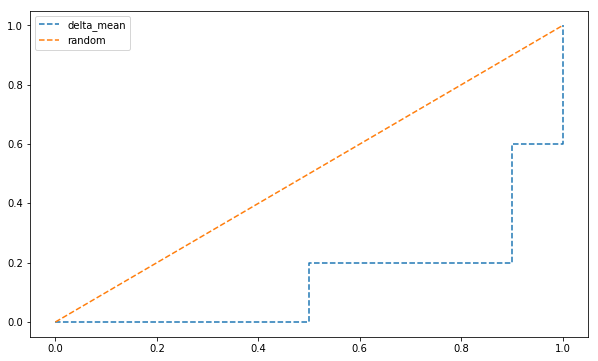

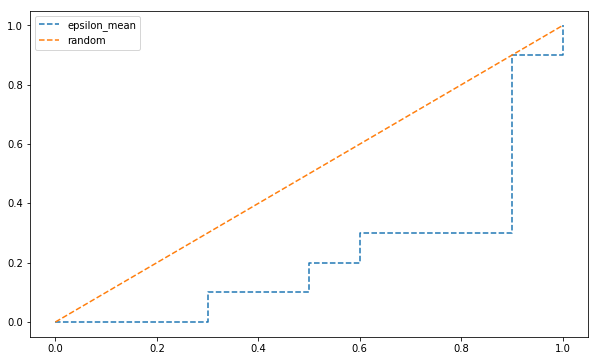

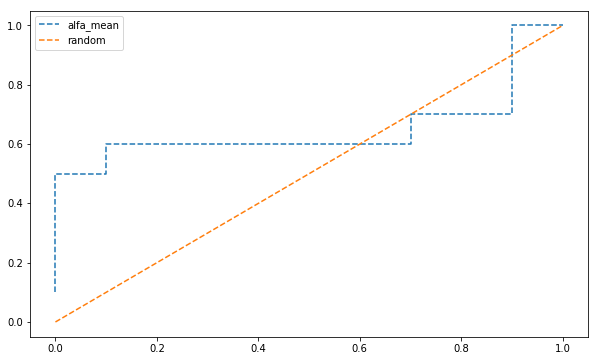

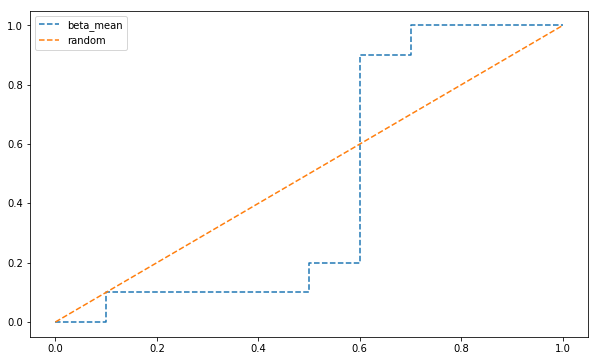

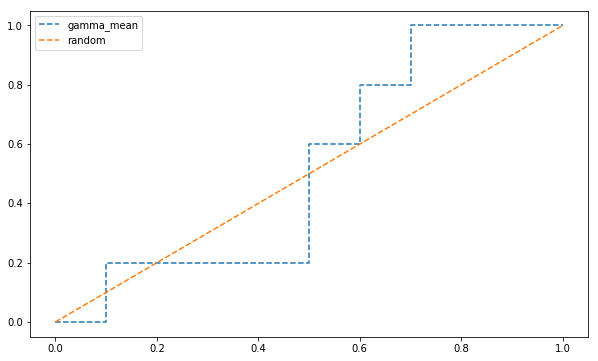

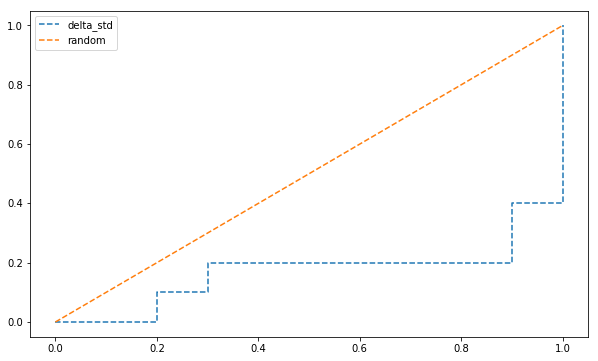

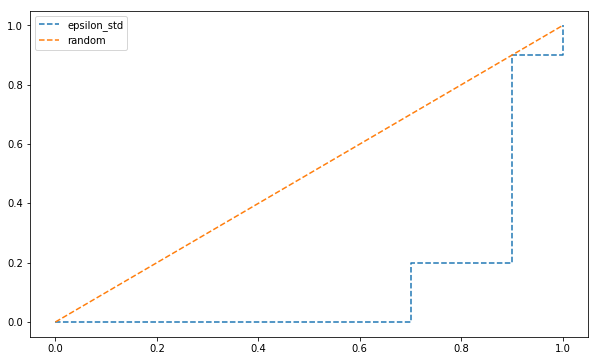

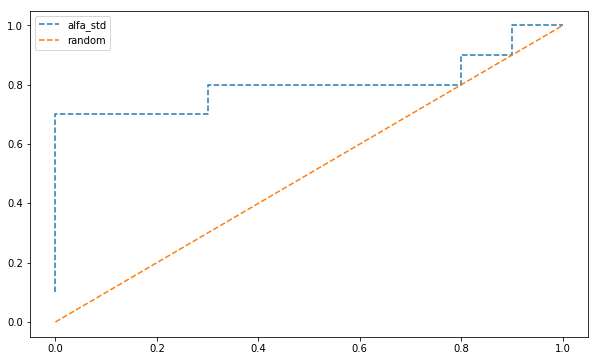

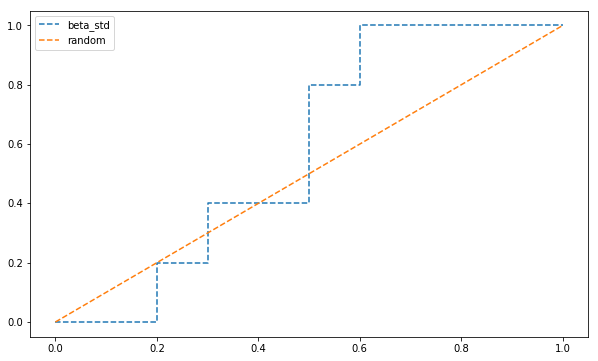

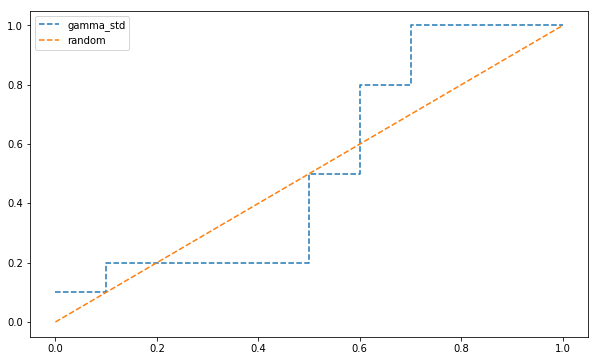

In [132]:
#bandas no normalizadas
print "Bandas NO NORMALIZADAS"
for banda in bandas_no_normalizadas.columns[:-1]:
    x,y,z = roc_curve(bandas_no_normalizadas['Tipo'], bandas_no_normalizadas[banda], pos_label='S')
    aucs[banda] = Max_AUC(bandas_no_normalizadas['Tipo'], bandas_no_normalizadas[banda])
    plt.plot(x,y, '--', label=banda)
    plt.plot([0,1], [0,1], '--', label='random')
    plt.legend(loc='best')
    plt.show()

Bandas NORMALIZADAS


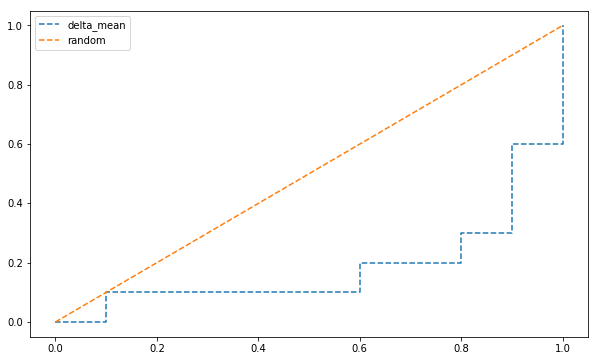

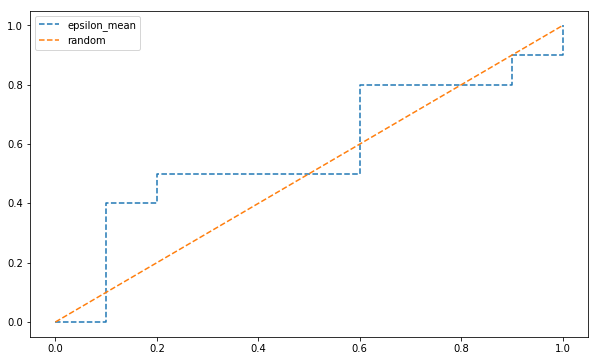

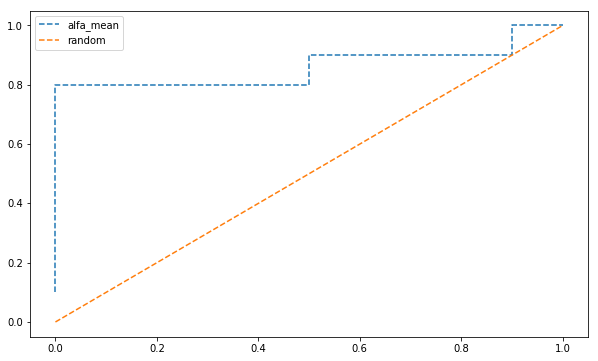

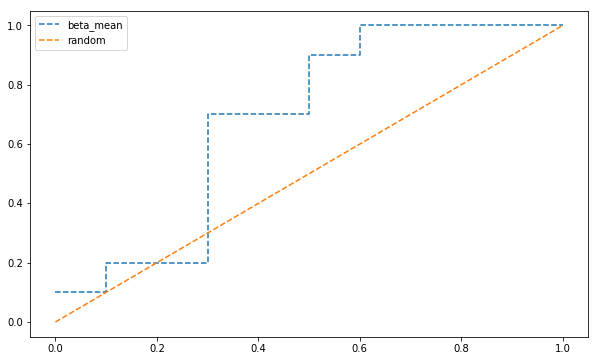

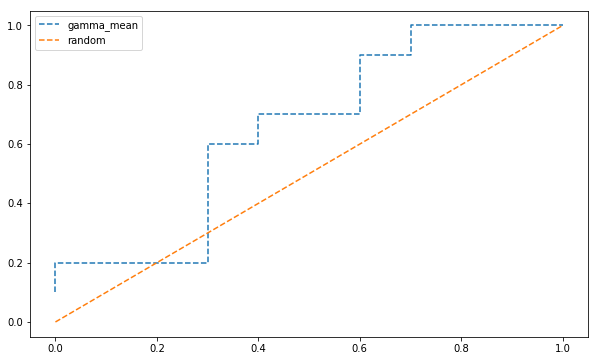

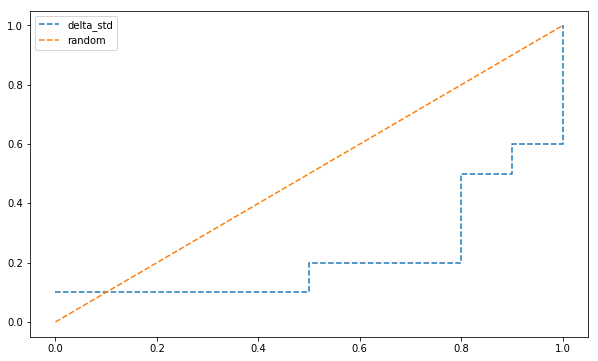

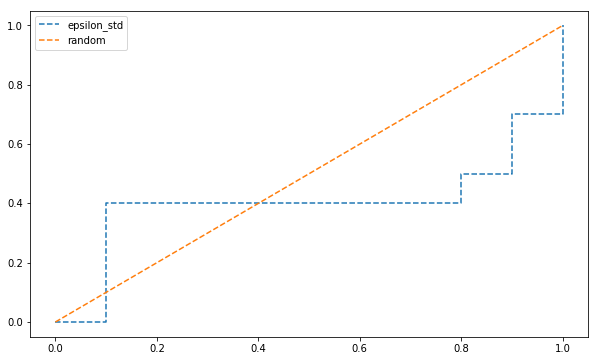

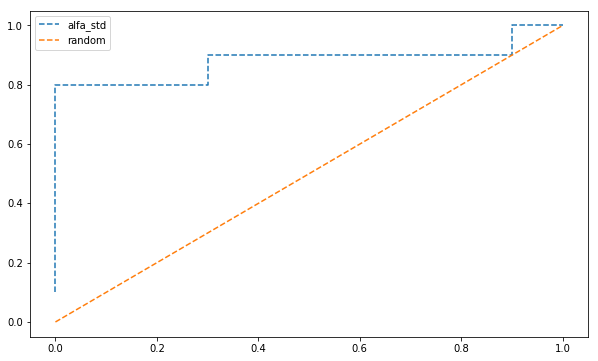

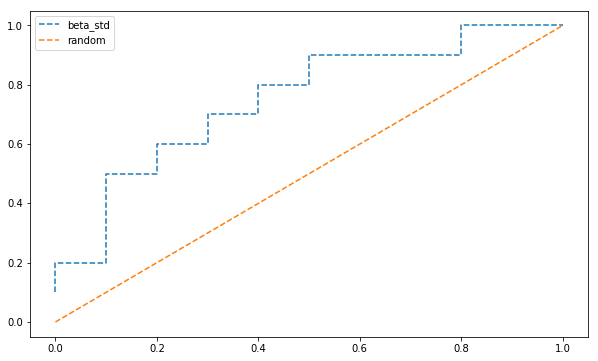

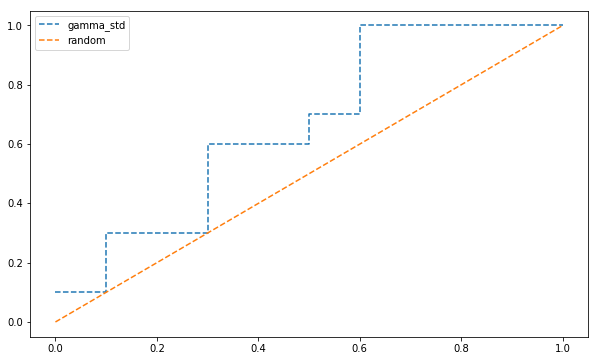

In [138]:
#bandas normalizadas
print "Bandas NORMALIZADAS"
for banda in bandas_normalizadas.columns[:-1]:
    x,y,z = roc_curve(bandas_normalizadas['Tipo'], bandas_normalizadas[banda], pos_label='S')
    aucs[banda+'_Norm'] = Max_AUC(bandas_normalizadas['Tipo'], bandas_normalizadas[banda])
    plt.plot(x,y, '--', label=banda)
    plt.plot([0,1], [0,1], '--', label='random')
    plt.legend(loc='best')
    plt.show()

In [139]:
aucs

mean_mutual_81_167    0.85
std_mutual81_167      0.82
mean_entropy          1.00
std_entropy           0.85
delta_mean            0.86
epsilon_mean          0.78
alfa_mean             0.65
beta_mean             0.55
gamma_mean            0.52
delta_std             0.83
epsilon_std           0.87
alfa_std              0.80
beta_std              0.58
gamma_std             0.52
delta_mean_Norm       0.82
epsilon_mean_Norm     0.57
alfa_mean_Norm        0.86
beta_mean_Norm        0.68
gamma_mean_Norm       0.65
delta_std_Norm        0.78
epsilon_std_Norm      0.60
alfa_std_Norm         0.88
beta_std_Norm         0.75
gamma_std_Norm        0.66
dtype: float64

### b) Utilizando una técnica de cross validación, estimar la performance de un classificador Logistic Regression para cada feature y graficar la curva ROC correspondiente. ¿Cuál es su conclución respecto a los resultados obtenidos en el punto anterior?


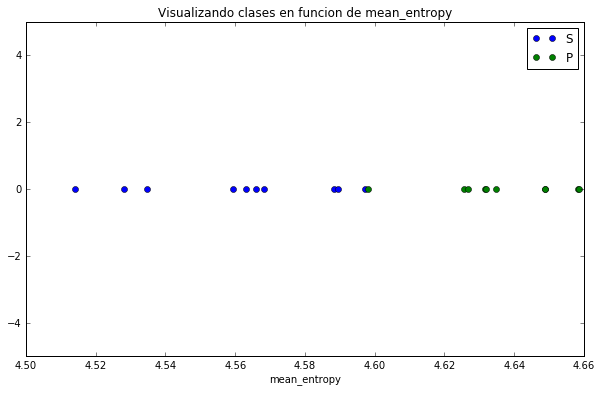

In [131]:
plt.plot(sorted(tablaCantBines[:10].mean_entropy), 
         [0 for x in range (0, 10)], 
         'o', label='S')

plt.plot(sorted(tablaCantBines[10:].mean_entropy), 
         [0 for x in range (0, 10)], 
         'o', label='P')

plt.legend(loc='best')
plt.title("Visualizando clases en funcion de mean_entropy")
plt.xlabel("mean_entropy")
plt.ylim(-5, 5)
plt.show()

Cuando intentamos realizar un fit de los la entropía media usando cross validation vemos que si bien los valores obtenidos para cada fold son idénticos al azar (parece que no está funcionando), parece predecir bien los labels del training set.
Sabemos que esto no es ideal pero por lo menos nos ayuda a ver que el modelo por lo menos se está fiteando.

In [123]:
def ROC_CV(X, y, model, n_splits=3, title=''):
    ##Calculando ROC auc más manualmente
    X = X.values.reshape(-1, 1)
    y = interelectrodo['Tipo']

    cv = StratifiedKFold(n_splits=3)
    classifier = model

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    figura = plt.figure()
    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1], pos_label='S')
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Azar', alpha=.8)
    #Computar curva media
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'ROC Media (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

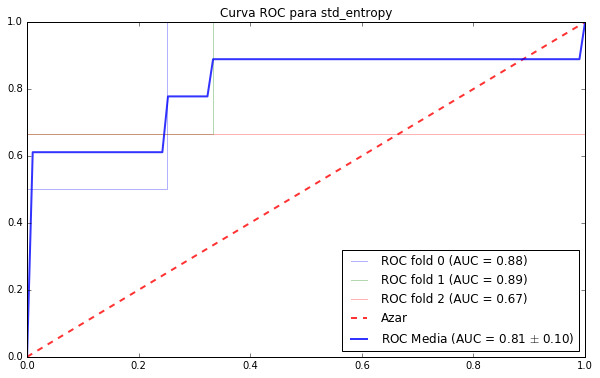

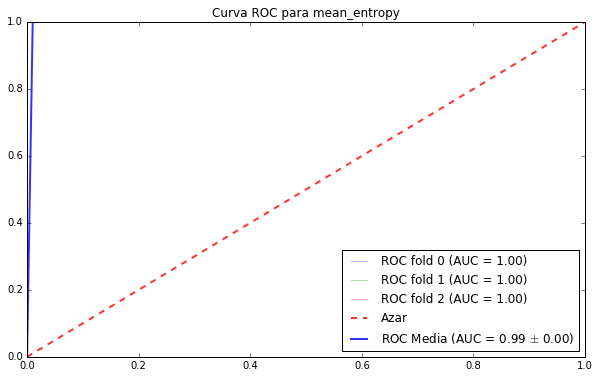

In [124]:
y = interelectrodo['Tipo']

ROC_CV(tablaCantBines['std_entropy'], y, LogisticRegression(), 
       title='Curva ROC para std_entropy')

ROC_CV(tablaCantBines['mean_entropy'], y, LogisticRegression(),
      title='Curva ROC para mean_entropy')

Calculando las curvas ROC de una manera menos automatizada encontramos que los valores bajo la curva obtenidos son los ideales en todos los folds para la entropía media, lo que es bastante raro.

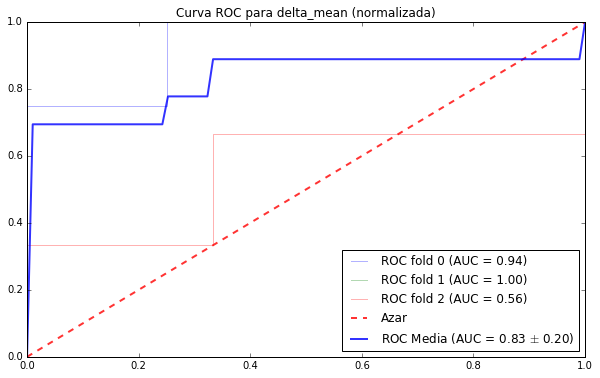

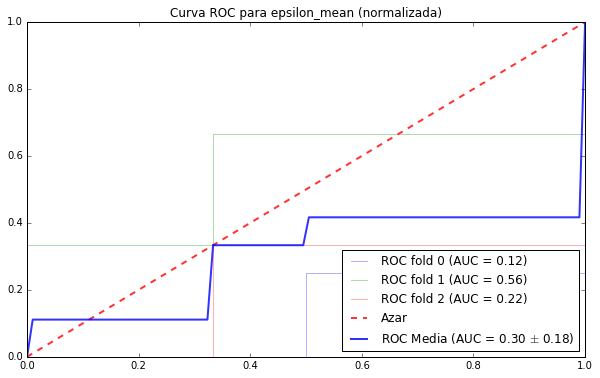

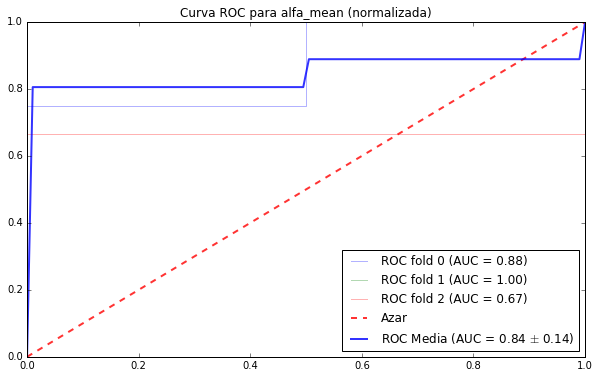

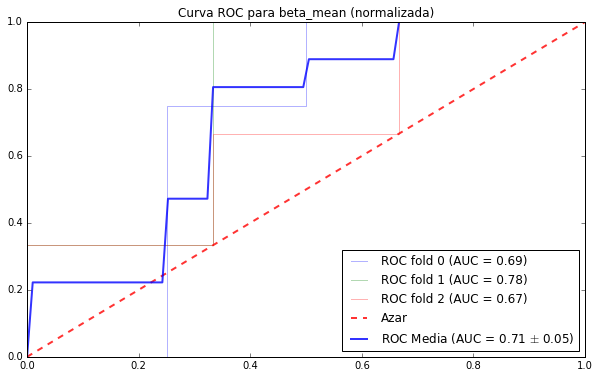

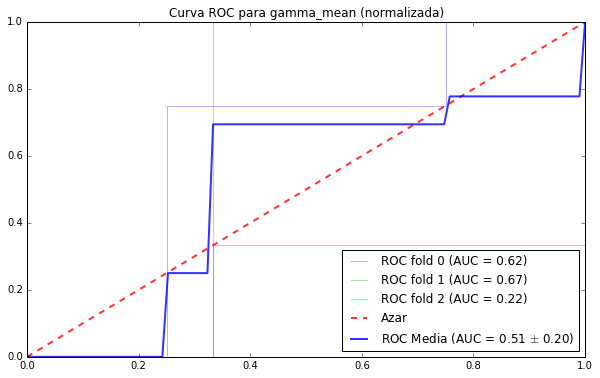

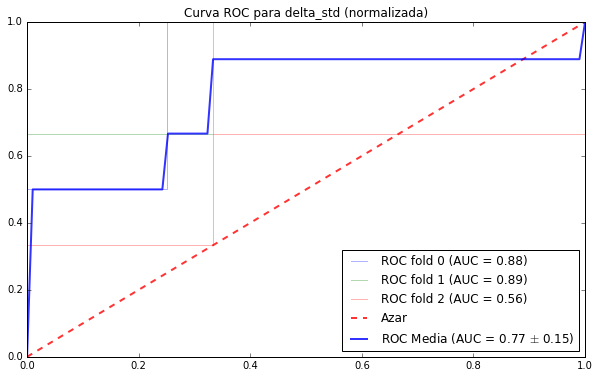

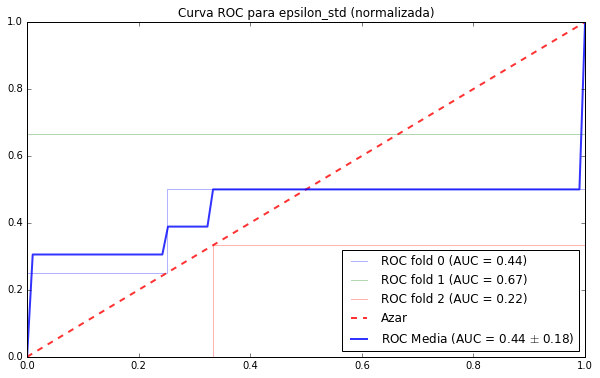

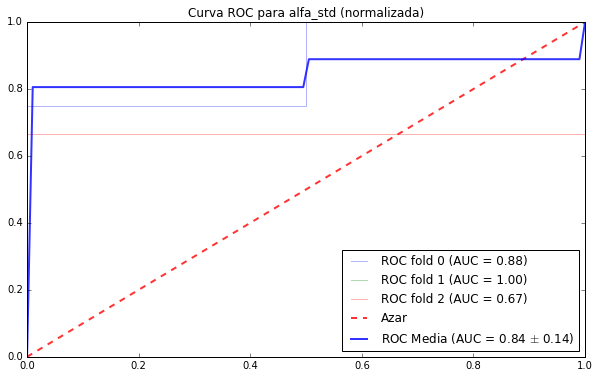

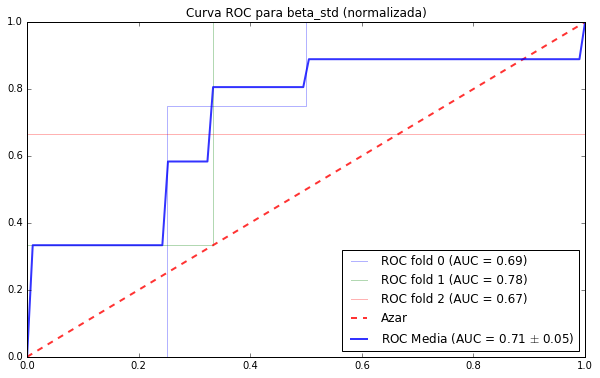

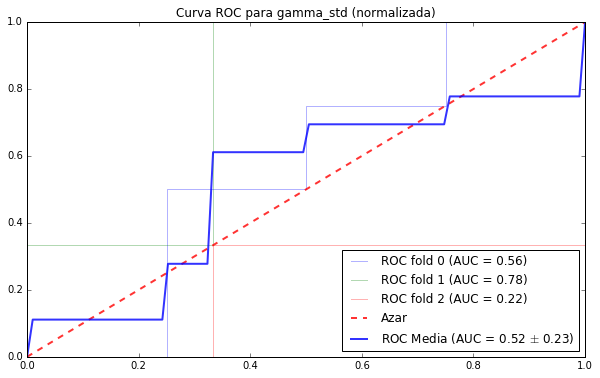

In [125]:
for banda in bandas_normalizadas.columns[:-1]:
    lr = LogisticRegression(penalty='l1')
    X = bandas_normalizadas[banda].apply(lambda x: x*1e2)
    ROC_CV(X, y, LogisticRegression(),
       title='Curva ROC para {} (normalizada)'.format(banda))

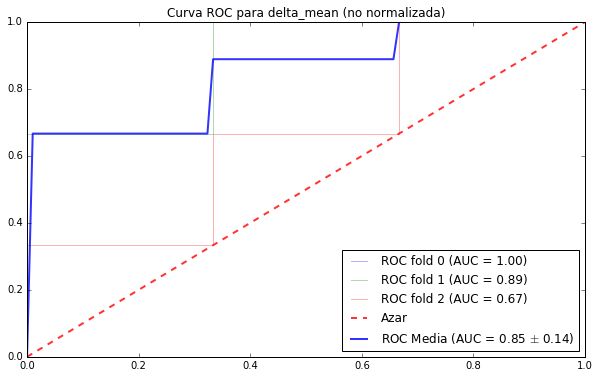

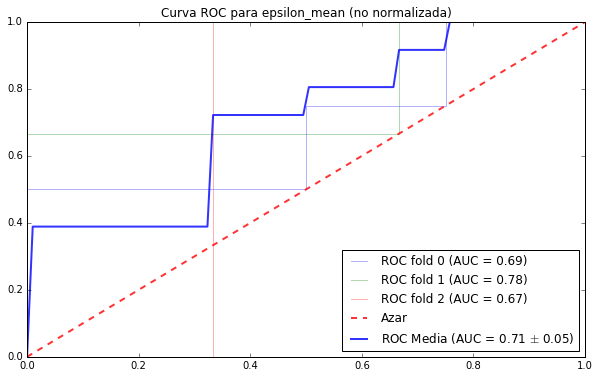

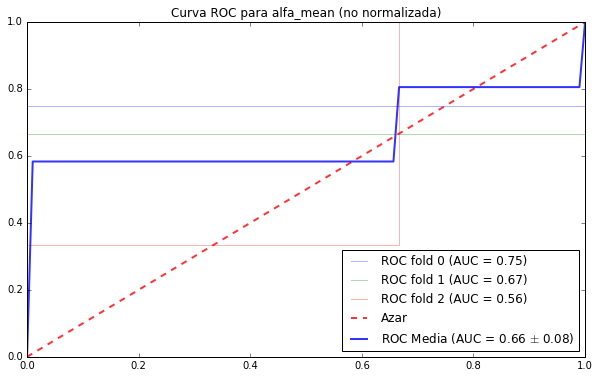

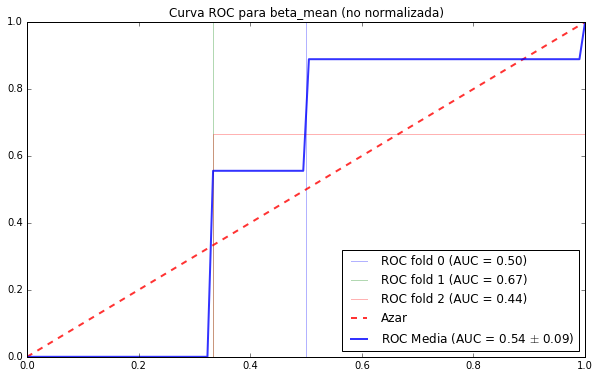

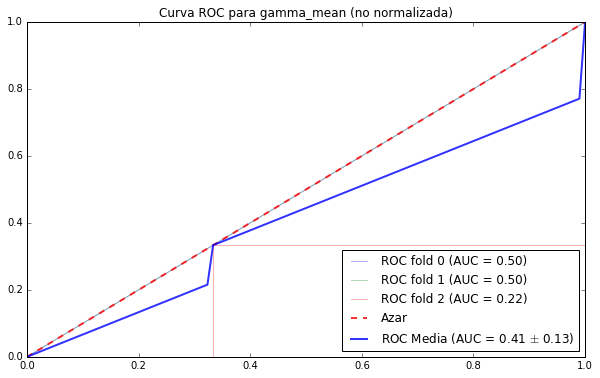

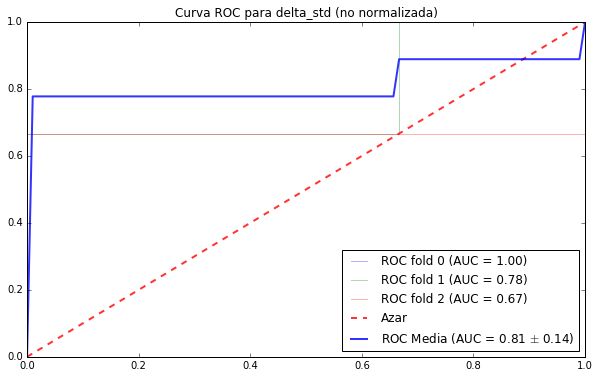

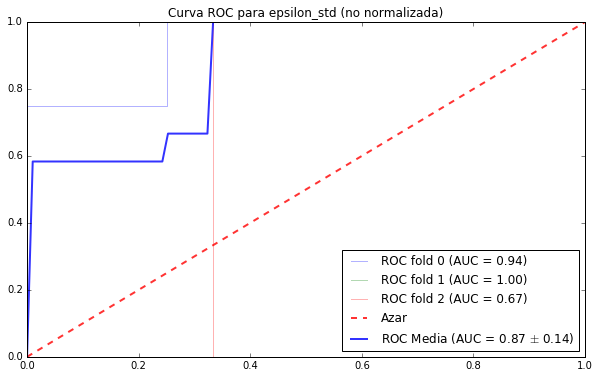

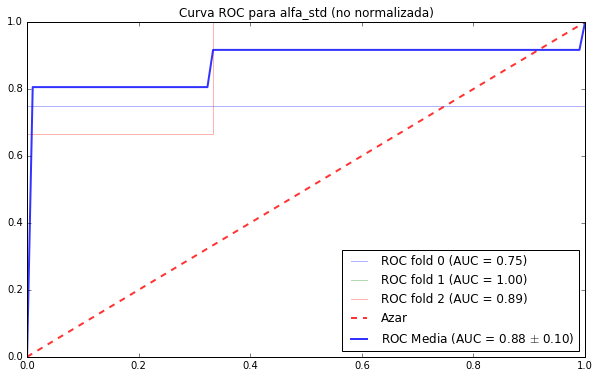

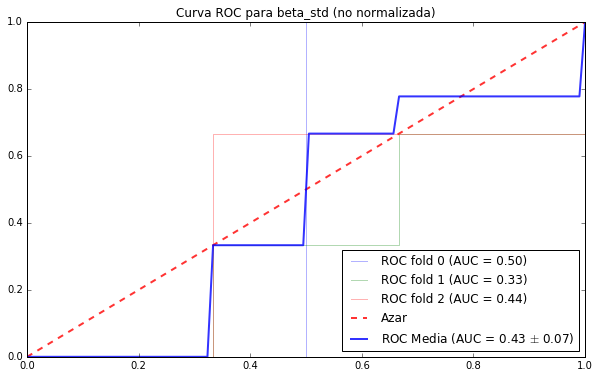

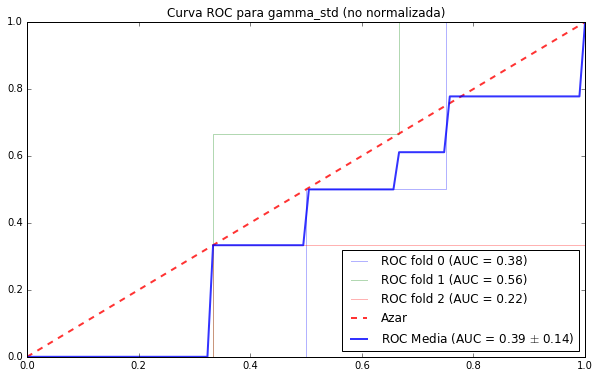

In [126]:
y = interelectrodo['Tipo']
for banda in bandas_no_normalizadas.columns[:-1]:
    escalar = -log(bandas_no_normalizadas[banda].min())
    X = bandas_no_normalizadas[banda].apply(lambda data: data*(1e13))
    ROC_CV(X, y, LogisticRegression(penalty='l1'),
           title="Curva ROC para {} (no normalizada)".format(banda))

In [127]:
features = []

#Mergeo todos los features en una sola columna
for i in range(20):
    feature_i = []
    for banda in bandas_no_normalizadas:
        if banda != 'Tipo':
            feature_i.append(bandas_no_normalizadas[banda][i])
    for banda in bandas_normalizadas:
        if banda != 'Tipo':
            feature_i.append(bandas_no_normalizadas[banda][i])
    
    feature_i.append(tablaCantBines['std_entropy'][i])
    feature_i.append(tablaCantBines['mean_entropy'][i])
    
    feature_i.append(interelectrodo['mean_mutual_81_167'][i])
    feature_i.append(interelectrodo['std_mutual81_167'][i])
    features.append(feature_i)

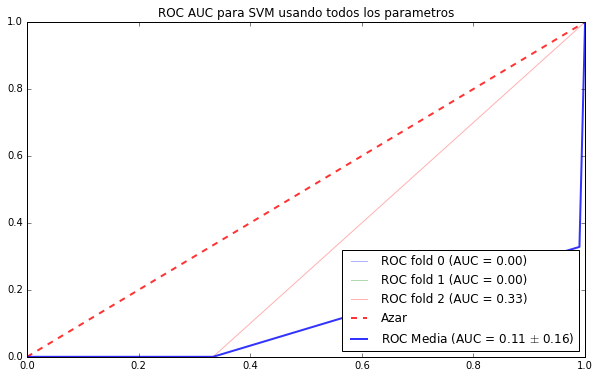

In [132]:
classifier = SVC(probability=True)
cv = StratifiedKFold(n_splits=3)

X = np.array(features)
y = interelectrodo['Tipo']

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1], pos_label='S')
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Azar', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'ROC Media (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

plt.title("ROC AUC para SVM usando todos los parametros")
plt.legend(loc='lower right')


plt.show()